In [1]:
from IPython.core.display import HTML
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
style_table = open('/Users/Scott/Desktop/Data/style-table.css').read()
style_notebook = open('/Users/Scott/Desktop/Data/style-notebook.css').read()
HTML('<style>{}</style>'.format(style_table + style_notebook))

# Best predictors of GPA success from a private school admissions profile using Random Forest


## Cleaning the Admissions Data
##### The first step was to take the admissions files and format them in Excel so that students who took the ISEE or SSAT entrance exams could be compared by looking at national percentile score. Also, admissions recommendations ratings shifted from a scale out of 4 to out of 5 over the years, so the scale needed to be standardized.

In [3]:
# Combines edited admissions files into a single dataframe with both ISEE and SSAT percentiles, 
# retaining that information.

# Puts admissions data files into a list, reads them, and creates a dataframe.
count = 4
files = []

for _ in range(5):
    files.append('/Users/Scott/Desktop/Data/Admissions/0'+str(count)+'_0'+str(count+1)+'.xlsx')
    count += 1
    
for _ in range(1):
    files.append('/Users/Scott/Desktop/Data/Admissions/0'+str(count)+'_'+str(count+1)+'.xlsx')
    count += 1
    
for _ in range(8):
    files.append('/Users/Scott/Desktop/Data/Admissions/'+str(count)+'_'+str(count+1)+'.xlsx')
    count += 1
    
counter = 0
for file in files:
    files[counter] = pd.read_excel(file)
    files[counter] = files[counter].dropna(axis=1, how="all")
    files[counter] = files[counter].dropna(axis=0, how="all")
    counter += 1

# df_allstudents is a dataframe of all admissions data
df_allstudents = pd.DataFrame()
for file in files:
    df_allstudents = pd.concat([df_allstudents, file], sort=True)

In [4]:
# Isolates certain columns to show cum. GPA, grades, testing, recommendation scores, sex, year of 
# entry and exit, grade applied to, financial aid, city, zip, has a sibling, has a parent who 
# attended, and has a faculty parent. Create a copy to void SettingwithCopyWarning later on.

allstudents_cleaner = df_allstudents[['Cum','Eng_Rec_Rating','English_1','Ethnicity','FA_Request',
                                      'FL_1','Grade_apply','History_1','Inquiry_source',
                                      'Interview','Math','Math_1','Math_rec_rating',
                                      'Princ_Rec_Rating','Quantitative','Reading',
                                      'School_admprevious','Science_1','Sex','Test','Verbal',
                                      'Writing','YOE','YOX','inq_FAM Family 1 [c]::P_city',
                                      'isFacultyStudent', 'isLegacy', 'isSibling',
                                      'NameLast']].copy()

In [5]:
# if no data, fill with 0 
fillna_list = ['FA_Request','isFacultyStudent','isLegacy','isSibling','Inquiry_source']

for col in fillna_list:
    allstudents_cleaner[col] = allstudents_cleaner.loc[:, col].fillna(value=0)

# replaces infrequent values with more general values
changes = [('3+',2.78), ('A/A-','A'),('A+/A','A+'),('A-/B-','B+'),('C+/B+','B'),('C+/A /A-','A-'),
           ('Multi-ethnic or Other (please describe)','Multi-Ethnic or Other'),
           ('Multi-Ethnic or Other/AsAm','Multi-Ethnic or Other'),
           ('Multi-Ethnic or Other/Asian, cauc','Multi-Ethnic or Other'),
           ('Multi-EthKoreameri','Multi-Ethnic or Other'),
           ('Multi-Eth As/Cauc','Multi-Ethnic or Other'),
           ('Middle Eastern Americasian amer','Multi-Ethnic or Other'),
           ('?','sf'),(44.00,4.00),('4-',3.06),('A-/sf','A-'),('Pass','sf')]
for change in changes:
    allstudents_cleaner = allstudents_cleaner.replace(change[0], change[1])
    
allstudents_cleaner = allstudents_cleaner[pd.notnull(allstudents_cleaner['YOX'])]

# chooses the most common value for empty values for any empty values
allstudents_cleaner = allstudents_cleaner.apply(lambda x:x.fillna(x.value_counts().index[0]))



## Cleaning the GPA Data


In [6]:
# creates ClassYear object that keeps the filename and year of exit (graduation) together
class ClassYear:
    def __init__(self, year):
        year_abbrev = '\'' + str(year)[2:]    # i.e. '08
        self.filename = '/Users/Scott/Desktop/Data/Academics/Class of ' + year_abbrev + ' GPA.xls'
        self.YOX = str(year-1) + "-" + str(year)
    
    def get_filename(self):
        return self.filename
    
    def get_YOX(self):
        return self.YOX

In [7]:
# Puts GPA data files into a list, reads them, and creates a dataframe of name, year of exit, and final GPA for merging

class_years = [ClassYear(year) for year in range(2008, 2018)]
    
# df_allacademics is a dataframe of all admissions data, include year of exit (graduation) column

df_allacademics = pd.DataFrame()
df_allacademics['YOX'] = pd.Series()

for grade in class_years:
    df_allacademics = pd.concat([df_allacademics, pd.read_excel(grade.filename)], sort=True)
    df_allacademics['YOX'] = df_allacademics['YOX'].fillna(value=grade.get_YOX())

In [8]:
# creates df of only name and GPA, sorted by name
df_allacademics = df_allacademics[['NameLast','YOX','3-8']].dropna(axis=0, how="all").sort_values(['NameLast'])
df_allacademics.columns = ['NameLast','YOX','Grad_GPA']


## Merge Admissions and GPA data to prepare for RandomForest

In [9]:
admissions_with_GPA = pd.merge(allstudents_cleaner, df_allacademics, on=['NameLast','YOX'])
admissions_with_GPA = admissions_with_GPA[admissions_with_GPA.Grad_GPA.notnull()]

In [10]:
# fun finding: students who come in 6th graduate with higher GPAs than those who come in 9th

sixes_or_nines = admissions_with_GPA.groupby(admissions_with_GPA.Grade_apply == 6).mean()
sixes_or_nines = sixes_or_nines['Grad_GPA'].to_frame()
sixes_or_nines = sixes_or_nines.rename({False: '9s', True: '6s'})
sixes_or_nines.columns = ['Cumulative GPA']
sixes_or_nines

,Cumulative GPA
Grade_apply,
9s,3.636868
6s,3.783627


In [11]:
# create dummy variables

courses = ['Ethnicity','Inquiry_source','Sex','YOE','YOX','inq_FAM Family 1 [c]::P_city',
        'English_1','FL_1','History_1','Math_1','Science_1','Test', 'School_admprevious']

data_w_dummies = admissions_with_GPA.drop(['NameLast','Cum'], axis=1)

counter = 0
for col in courses:
    foo = pd.get_dummies(data_w_dummies[col], prefix=col)
    data_w_dummies = pd.concat([data_w_dummies.drop(col, axis=1), foo], axis=1, join='inner')
    counter += 1

In [12]:
# set up training and testing data

# move Grad_GPA to end of the df for easy feature selection slicing
data_w_dummies = data_w_dummies.reset_index().drop(['index'], axis=1).copy()
cols = data_w_dummies.columns.tolist()
cols.insert(len(cols)-1, cols.pop(cols.index('Grad_GPA')))
df = data_w_dummies[cols].copy()

sixes = df[df.Grade_apply==6].copy()
nines = df[df.Grade_apply==9].copy()

df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75

sixes['is_train'] = np.random.uniform(0, 1, len(sixes)) <= .75
nines['is_train'] = np.random.uniform(0, 1, len(nines)) <= .75

train, test = df[df['is_train']==True], df[df['is_train']==False]

train_sixes, test_sixes = sixes[sixes['is_train']==True], sixes[sixes['is_train']==False]
train_nines, test_nines = nines[nines['is_train']==True], nines[nines['is_train']==False]

# features are everything but last two columns
features = df.columns[:(len(df.columns)-2)]
features_sixes = sixes.columns[:(len(sixes.columns)-2)]
features_nines = nines.columns[:(len(nines.columns)-2)]

In [13]:
# random forests for all, sixes, and nines

clf = RandomForestRegressor()
sixes_rf = RandomForestRegressor()
nines_rf = RandomForestRegressor()

X = train[features]
y = train['Grad_GPA']
clf.fit(X,y)

X_sixes = train_sixes[features_sixes]
y_sixes = train_sixes['Grad_GPA']
sixes_rf.fit(X_sixes,y_sixes)

X_nines = train_nines[features_nines]
y_nines = train_nines['Grad_GPA']
nines_rf.fit(X_nines,y_nines)

preds = clf.predict(test[features])
results = pd.crosstab(test['Grad_GPA'], preds, rownames=['actual'], 
                      colnames=['preds'])

preds_sixes = sixes_rf.predict(test_sixes[features_sixes])
results_sixes = pd.crosstab(test_sixes['Grad_GPA'], preds_sixes, rownames=['actual'], 
                            colnames=['preds'])

preds_nines = nines_rf.predict(test_nines[features_nines])
results_nines = pd.crosstab(test_nines['Grad_GPA'], preds_nines, rownames=['actual'], 
                            colnames=['preds'])

In [14]:
def Grid_Search_CV_RFR(X_train, y_train):
    estimator = RandomForestRegressor()
    param_grid = { 
            "n_estimators"      : [10,20,30],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,8],
            "bootstrap": [True, False],
            }

    grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

    grid.fit(X_train, y_train)

    return grid.best_score_ , grid.best_params_


In [15]:
grid_search_all = Grid_Search_CV_RFR(X,y)
grid_search_sixes = Grid_Search_CV_RFR(X_sixes,y_sixes)
grid_search_nines = Grid_Search_CV_RFR(X_nines,y_nines)

In [16]:
# regression for whole dataset

from sklearn.ensemble import RandomForestRegressor

test_x = test[features]
train_x = train[features]
X = train_x
y= train['Grad_GPA']

rf = RandomForestRegressor(n_jobs=-1)
estimator = rf.set_params(bootstrap=grid_search_all[1]['bootstrap'], 
                          max_features=grid_search_all[1]['max_features'],
                          min_samples_split=grid_search_all[1]['min_samples_split'],
                          n_estimators=grid_search_all[1]['n_estimators'])
estimator.fit(X,y)

GPA_reshape = test['Grad_GPA'].values

print("R2 score:", estimator.score(test_x, GPA_reshape))

estimator.feature_importances_

df_all = pd.DataFrame(estimator.feature_importances_, test_x.columns.values)
df_all.columns = ['correlations']
df_all = df_all.sort_values('correlations', ascending=False)

R2 score: 0.37960999343312374


In [17]:
df_all = df_all.round(3)
df_all.head(10)

,correlations
Verbal,0.092
Quantitative,0.070
Reading,0.062
Science_1_B,0.038
Princ_Rec_Rating,0.031
Math,0.029
Writing,0.024
Eng_Rec_Rating,0.024
School_admprevious_KIPP Bayview Academy,0.022
Math_rec_rating,0.019


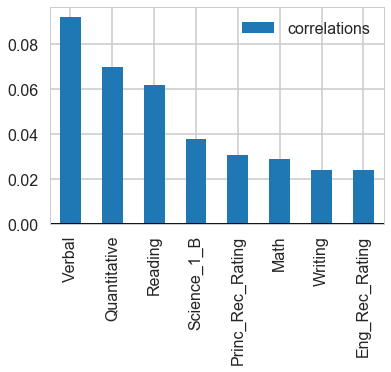

In [18]:
df_all[0:8].plot(kind='bar'); plt.axhline(0, color='k')

In [19]:
# regression for sixes

from sklearn.ensemble import RandomForestRegressor

test_x_sixes= test_sixes[features_sixes]
train_x_sixes= train_sixes[features_sixes]
X = train_x_sixes
y = train_sixes['Grad_GPA']

rf = RandomForestRegressor(n_jobs=-1)
estimator = rf.set_params(bootstrap=grid_search_sixes[1]['bootstrap'], 
                          max_features=grid_search_sixes[1]['max_features'],
                          min_samples_split=grid_search_sixes[1]['min_samples_split'],
                          n_estimators=grid_search_sixes[1]['n_estimators'])

estimator.fit(X,y)

cum_reshape = test_sixes['Grad_GPA'].values

print ("R2 score:", estimator.score(test_x_sixes, cum_reshape))

estimator.feature_importances_

df_6 = pd.DataFrame(estimator.feature_importances_, test_x_sixes.columns.values)
df_6.columns = ['correlations']
df_6 = df_6.sort_values('correlations', ascending=False)
df_6.head(10)

R2 score: 0.20329489001289613


,correlations
Verbal,0.290353
Quantitative,0.100388
Math,0.095906
Math_rec_rating,0.044268
School_admprevious_Belmont Oaks Academy,0.035194
Eng_Rec_Rating,0.033405
Reading,0.032350
Ethnicity_Caucasian,0.028379
Princ_Rec_Rating,0.025186
FA_Request,0.023868


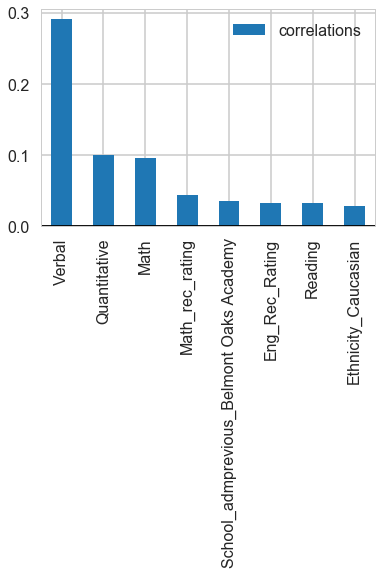

In [20]:
df_6[0:8].plot(kind='bar'); plt.axhline(0, color='k')

In [21]:
# regression for nines

from sklearn.ensemble import RandomForestRegressor

test_x_nines= test_nines[features_nines]
train_x_nines= train_nines[features_nines]
X = train_x_nines
y = train_nines['Grad_GPA']

rf = RandomForestRegressor(n_jobs=-1)
estimator = rf.set_params(bootstrap=grid_search_nines[1]['bootstrap'], 
                          max_features=grid_search_nines[1]['max_features'],
                          min_samples_split=grid_search_nines[1]['min_samples_split'],
                          n_estimators=grid_search_nines[1]['n_estimators'])

estimator.fit(X,y)

cum = test_nines['Grad_GPA'].values

print ("R2 score:", estimator.score(test_x_nines, cum))

estimator.feature_importances_

df_9 = pd.DataFrame(estimator.feature_importances_, test_x_nines.columns.values)
df_9.columns = ['correlations']
df_9 = df_9.sort_values('correlations', ascending=False)
df_9.head(10)

R2 score: 0.4716638849464228


,correlations
Verbal,0.114953
Quantitative,0.103755
Reading,0.083305
Math,0.044966
Princ_Rec_Rating,0.024200
Eng_Rec_Rating,0.020638
YOX_2009-2010,0.019967
"Ethnicity_African American, Black",0.019361
Writing,0.018658
School_admprevious_KIPP Bayview Academy,0.018635


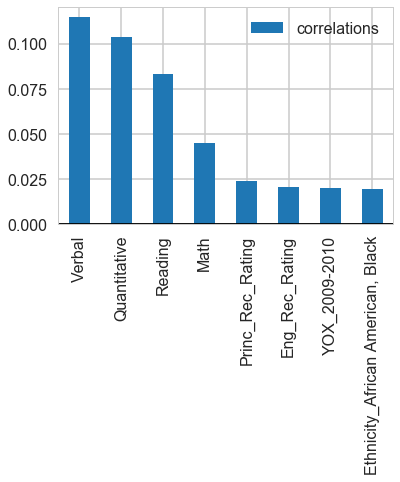

In [22]:
df_9[0:8].plot(kind='bar'); plt.axhline(0, color='k')

## Takeaways
#### While the r^2 shows that an admissions profile is quite a poor predictor of academic success, although 9th grade admitted students much better than 6th, it is still interesting to see that 9th grade Verbal standardized test scores are much more predictive of success (9 times) than, say, math scores.
#### Another interesting finding, below, is that while 9th graders have slightly higher admissions test scores, students who come in 6th grade graduate with higher GPAs, suggesting that the strong middle school education gives the students an advantage in high school

In [23]:
# plot changes over time by finding average 
df_tests = list(['Reading']+['Quantitative']+
                      ['Verbal']+['Math'])
tests = df.copy()[df_tests]
tests['avg']= tests.mean(1)

In [24]:
tests_sixes = sixes.copy()[df_tests]
tests_sixes['avg6']= tests_sixes.mean(1)
tests_sixes.describe()

,Reading,Quantitative,Verbal,Math,avg6
count,182.000000,182.000000,182.000000,182.000000,182.000000
mean,73.510989,80.483516,78.752747,80.917582,78.416209
std,22.388765,20.142236,19.489319,19.408912,15.915117
min,1.000000,4.000000,9.000000,14.000000,25.750000
25%,64.000000,72.000000,67.250000,73.000000,69.812500
50%,77.000000,88.000000,84.000000,87.000000,82.750000
75%,91.500000,96.750000,94.000000,96.000000,91.687500
max,99.000000,99.000000,99.000000,99.000000,99.000000


,6th entrance tests,9th entrance tests
25%,69.8125,72.50
50%,82.7500,85.75
75%,91.6875,92.00
max,99.0000,99.00


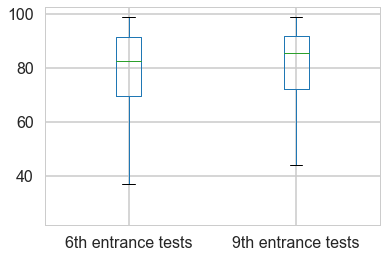

In [25]:
tests_nines = nines.copy()[df_tests]
tests_nines['avg9']= tests_nines.mean(1)
tests_nines.describe()

tests = pd.concat([tests_sixes['avg6'].to_frame(), tests_nines['avg9'].to_frame()], axis = 1)
tests = tests.rename(index=str, columns={'avg6':'6th entrance tests','avg9':'9th entrance tests'})

tests.boxplot()
desc = tests.describe().drop((['count','mean', 'std', 'min']))
desc



,6s GPAs,9s GPAs
25%,3.59,3.40
50%,3.83,3.70
75%,4.04,3.96


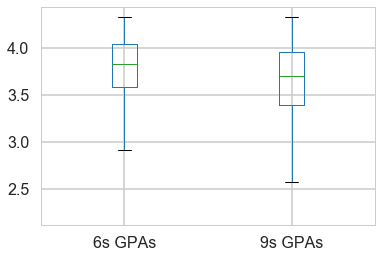

In [26]:
sixes_v_nines = pd.DataFrame({ '6s GPAs' : sixes['Grad_GPA'],'9s GPAs' : nines['Grad_GPA']})
sixes_v_nines.boxplot()

desc = sixes_v_nines.describe().drop((['count','mean', 'std', 'min', 'max']))
desc.round(2)